In [ ]:
from pylab import plt
plt.style.use('seaborn')
import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'
import datetime as dt
import warnings; warnings.simplefilter('ignore')

## Implied Volatilities

In [ ]:
def bsm_call_value(S0, K, T, r, sigma):
    from math import log, sqrt, exp
    from scipy import stats

    S0 = float(S0)
    d1 = (log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    d2 = (log(S0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    value = (S0 * stats.norm.cdf(d1, 0.0, 1.0)
            - K * exp(-r * T) * stats.norm.cdf(d2, 0.0, 1.0))
      # stats.norm.cdf --> cumulative distribution function
      #                    for normal distribution
    return value


In [ ]:
# Vega function and Imp Volatility

def bsm_vega(S0, K, T, r, sigma):
    from math import log, sqrt
    from scipy import stats
    S0 = float(S0)
    d1 = (log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    vega = S0 * stats.norm.pdf(d1, 0.0, 1.0) * sqrt(T)
    return vega
# Implied Volatility
def bsm_call_imp_vol(S0, K, T, r, C0, sigma_est, it=100):
    for i in range(it):
        sigma_est -= ((bsm_call_value(S0, K, T, r, sigma_est) - C0)
                        / bsm_vega(S0, K, T, r, sigma_est))
    return sigma_est

In [ ]:
V0 = 17.6639

In [ ]:
r = 0.01

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
path='/content/drive/MyDrive/Colab Notebooks/A_Hilpisch/py4fi-master/jupyter36/source'
h5 = pd.HDFStore(path+'/vstoxx_data_31032014.h5', 'r')
futures_data = h5['futures_data']  # VSTOXX futures data
options_data = h5['options_data']  # VSTOXX call option data
h5.close()

In [ ]:
futures_data.head()

,DATE,EXP_YEAR,EXP_MONTH,PRICE,MATURITY,TTM
496,2014-03-31,2014,4,17.85,2014-04-18,0.049
497,2014-03-31,2014,5,19.55,2014-05-16,0.126
498,2014-03-31,2014,6,19.95,2014-06-20,0.222
499,2014-03-31,2014,7,20.40,2014-07-18,0.299
500,2014-03-31,2014,8,20.70,2014-08-15,0.375


In [ ]:
futures_data

,DATE,EXP_YEAR,EXP_MONTH,PRICE,MATURITY,TTM
496,2014-03-31,2014,4,17.85,2014-04-18,0.049
497,2014-03-31,2014,5,19.55,2014-05-16,0.126
498,2014-03-31,2014,6,19.95,2014-06-20,0.222
499,2014-03-31,2014,7,20.40,2014-07-18,0.299
500,2014-03-31,2014,8,20.70,2014-08-15,0.375
501,2014-03-31,2014,9,20.95,2014-09-19,0.471
502,2014-03-31,2014,10,21.05,2014-10-17,0.548
503,2014-03-31,2014,11,21.25,2014-11-21,0.644


In [ ]:
options_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395 entries, 46170 to 46564
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   DATE       395 non-null    datetime64[ns]
 1   EXP_YEAR   395 non-null    int64         
 2   EXP_MONTH  395 non-null    int64         
 3   TYPE       395 non-null    object        
 4   STRIKE     395 non-null    float64       
 5   PRICE      395 non-null    float64       
 6   MATURITY   395 non-null    datetime64[ns]
 7   TTM        395 non-null    float64       
dtypes: datetime64[ns](2), float64(3), int64(2), object(1)
memory usage: 27.8+ KB


In [ ]:
options_data[['DATE', 'MATURITY', 'TTM', 'STRIKE', 'PRICE']].head()

,DATE,MATURITY,TTM,STRIKE,PRICE
46170,2014-03-31,2014-04-18,0.049,1.0,16.85
46171,2014-03-31,2014-04-18,0.049,2.0,15.85
46172,2014-03-31,2014-04-18,0.049,3.0,14.85
46173,2014-03-31,2014-04-18,0.049,4.0,13.85
46174,2014-03-31,2014-04-18,0.049,5.0,12.85


In [ ]:
options_data['IMP_VOL'] = 0.0
  # new column for implied volatilities

In [ ]:
tol = 0.5  # tolerance level for moneyness
for option in options_data.index:
    # iterating over all option quotes
    forward = futures_data[futures_data['MATURITY'] == \
                options_data.loc[option]['MATURITY']]['PRICE'].values[0]
      # picking the right futures value
    if (forward * (1 - tol) < options_data.loc[option]['STRIKE']
                             < forward * (1 + tol)):
        # only for options with moneyness within tolerance
        imp_vol = bsm_call_imp_vol(
                V0,  # VSTOXX value 
                options_data.loc[option]['STRIKE'],
                options_data.loc[option]['TTM'],
                r,   # risk free rate
                options_data.loc[option]['PRICE'],
                sigma_est=2.,  # estimate for implied volatility to start Newton
                it=100 )        # number of iteration
        options_data.loc[option, 'IMP_VOL'] = imp_vol

In [ ]:
futures_data['MATURITY']
  # select the column with name MATURITY

496   2014-04-18
497   2014-05-16
498   2014-06-20
499   2014-07-18
500   2014-08-15
501   2014-09-19
502   2014-10-17
503   2014-11-21
Name: MATURITY, dtype: datetime64[ns]

In [ ]:
options_data.loc[46170]
  # select data row for index 46170

DATE         2014-03-31 00:00:00
EXP_YEAR                    2014
EXP_MONTH                      4
TYPE                           C
STRIKE                       1.0
PRICE                      16.85
MATURITY     2014-04-18 00:00:00
TTM                        0.049
IMP_VOL                      0.0
Name: 46170, dtype: object

In [ ]:
options_data.loc[46170]['STRIKE']
  # select only the value in column STRIKE
  # for index 46170 

1.0

In [ ]:
plot_data = options_data[options_data['IMP_VOL'] > 0]

In [ ]:
maturities = sorted(set(options_data['MATURITY']))
maturities

[Timestamp('2014-04-18 00:00:00'),
 Timestamp('2014-05-16 00:00:00'),
 Timestamp('2014-06-20 00:00:00'),
 Timestamp('2014-07-18 00:00:00'),
 Timestamp('2014-08-15 00:00:00'),
 Timestamp('2014-09-19 00:00:00'),
 Timestamp('2014-10-17 00:00:00'),
 Timestamp('2014-11-21 00:00:00')]

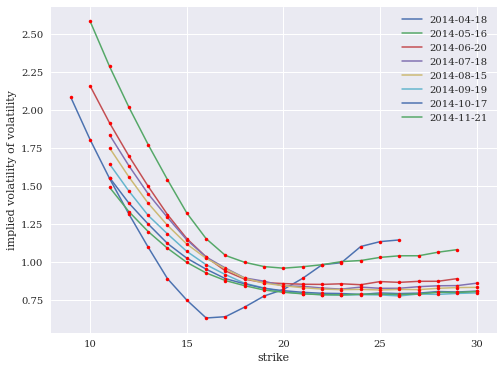

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(8, 6))
for maturity in maturities:
    data = plot_data[options_data.MATURITY == maturity]
      # select data for this maturity
    plt.plot(data['STRIKE'], data['IMP_VOL'],
             label=maturity.date(), lw=1.5)
    plt.plot(data['STRIKE'], data['IMP_VOL'], 'r.', label='')
plt.grid(True) 
plt.xlabel('strike')
plt.ylabel('implied volatility of volatility')
plt.legend()
plt.show()
#plt.title('Implied volatilities (of volatility) for European call options on the VSTOXX on 31. March 2014')
# tag: vs_imp_vol